# Notebook 7 - Creating Orientation Data from Strike Data

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from WMS Services or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook will present how vector data can be loaded into GemGIS with the [GeoPandas](https://geopandas.org/) package and how it can be manipulated for the usage in [GemPy](https://github.com/cgre-aachen/gempy). This includes the extraction of coordinates and height values from a GeoDataFrame and DEM, respectively. 

- [What are Interfaces and Orientations?](#intandor)
- [What is GemPy?](#gempy)
- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)


<a id='intandor'></a>
## What are Interfaces and Orientations?
`GemPy`is using an implicit modeling approach based on the potential field method to create geological models. The only input data required are interfaces (layer boundaries in outcrops or in wells) and orientations (dip and azimuth values of a given orientation). The necessary information for interfaces are the `X`,`Y` and `Z`coordinates as well as the `formation`. Please be aware that `GemPy` is always referring to the base of a formation! For orientations, `X`,`Y` and `Z`coordinates, the `formation` and `dip`, `azimuth` and a `polarity` values is needed. The polarity is usually set to 1. 

Strike, in geology, is the direction of the line formed by the intersection of a fault, bed, or other planar feature and a horizontal plane. Strike indicates the dip orientation or position of linear structural features such as faults, beds, joints, and folds.

<img src="../data/Images/orientations.jpg" width="500">

Source: https://www.britannica.com/science/strike-geology <br>
Image from: Geological Structures: a Practical Introduction -  John W.F. Waldron and Morgan Snyder 


<a id='gempy'></a>
## What is GemPy?

`GemPy` is a Python-based, **open-source geomodeling library**. It is
capable of constructing complex **3D geological models** of folded
structures, fault networks and unconformities, based on the underlying
powerful **implicit representation** approach. `GemPy` was designed from the
ground up to support easy embedding in probabilistic frameworks for the
uncertainty analysis of subsurface structures.

Check out the documentation either on the main website (https://www.gempy.org/) or the specific docs site (http://docs.gempy.org/).

- GemPy Installation Help: https://docs.gempy.org/installation.html
- GemPy Tutorials: https://docs.gempy.org/tutorials/index.html
- GemPy Examples: https://docs.gempy.org/examples/index.html
- GemPy Repository: https://github.com/cgre-aachen/gempy
- GemPy Tutorial Video: https://youtu.be/n0btC5Zilyc




<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is currently under development and only available at https://github.com/cgre-aachen/gemgis. pip and conda versions including a documentations page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load WMS services as arrays/rasters
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data




If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class in later tutorials, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.6.1 is the latest stable version that is supported by GemGIS***. Rasterio objects and a general introduction to working with raster in GemGIS is provided in the next notebook.

In [1]:
import sys
sys.path.append('../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
print(gg)

<module 'gemgis' from '../../gemgis\\gemgis\\__init__.py'>


<a id='vreport'></a>
# Version Reports
Reporting your Python environment's package versions and hardware resources by Scooby - https://github.com/banesullivan/scooby. This overview shows the packages and their versions used to run this notebook. Upgrading or downgrading to older or newer versions may break the notebook.

In [2]:
gg.Report()

--------------------------------------------------------------------------------
  Date: Tue Jul 28 22:11:39 2020 W. Europe Daylight Time

                OS : Windows
            CPU(s) : 24
           Machine : AMD64
      Architecture : 64bit
               RAM : 63.9 GB
       Environment : Jupyter

  Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]

              json : 2.0.9
             numpy : 1.18.5
            scooby : 0.5.2
            owslib : 0.17.0
            pandas : 1.0.5
           shapely : 1.6.4.post1
           pyvista : 0.25.3
          rasterio : 1.0.21
         geopandas : 0.6.1
          requests : 2.24.0
             scipy : 1.5.0
        matplotlib : 3.2.2

  Intel(R) Math Kernel Library Version 2020.0.1 Product Build 20200208 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------

# Example 1 - Extract Orientations from a W-E striking planar surface

As a first example we will extract orientation values based on intersections of layer boundaries (purple) with topography (green). Intersecting points with the same altitude can be connected to form strike lines (purple lines). These lines represent isolines of outcropping layers assuming that the topography is horizontal (green planes). Based on the contour spacing and the height difference, the slope and hence the dipping angle $\theta$ can be estimated according to

$$tan(\theta) = m = \frac{\Delta y}{\Delta x}$$

and 

$$\theta = tan^{-1}\left( \frac{\Delta y}{\Delta x}\right)$$.

<img src="../data/Images/orientations.jpg" width="500">

Image from: Geological Structures: a Practical Introduction -  John W.F. Waldron and Morgan Snyder 

## Load Data

In [3]:
geological_map = rasterio.open('../../gemgis/data/Test1/task1.tif')
gdf = gpd.read_file('../../gemgis/data/Test1/points_strike.shp')

## Inspect Data

**In order for GemGIS to be able to calculate the orientations, a unique ID needs to be provided for each set of strike points. GemGIS will then calculate the strike between strike line 1 and 2, 2 and 3 and so forth. This way, altitudes can be present multiple times as it is the common case for folds.**

In [4]:
gdf.head()

id    Z formation                 geometry
0   2  400       Ton   POINT (62.513 382.832)
1   3  500       Ton  POINT (141.489 555.155)
2   4  600       Ton  POINT (191.943 720.949)
3   5  700       Ton  POINT (287.541 893.302)
4   5  700       Ton  POINT (481.908 893.302)

## Set Extent

In [5]:
extent = gg.utils.set_extent(0,972,0,1069)
extent

[0, 972, 0, 1069]

## Plot Data

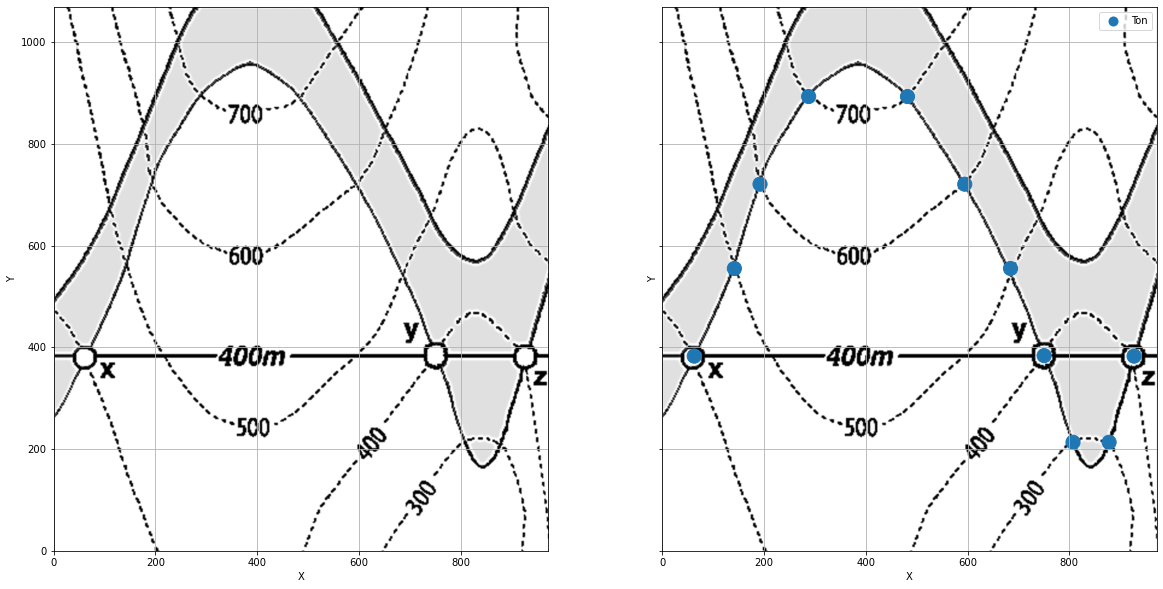

In [6]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, s = 200)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Create LineString GeoDataFrame

We are creating a LineString GeoDataFrame based on the points to visualize the strike lines. 

In [7]:
linestring_gdf = gg.utils.create_linestring_gdf(gdf)
linestring_gdf

geometry    Z formation
0      LINESTRING (807.441 213.514, 878.392 213.516)  300       Ton
1  LINESTRING (62.513 382.832, 750.576 383.831, 9...  400       Ton
2      LINESTRING (141.489 555.155, 684.515 555.153)  500       Ton
3      LINESTRING (191.943 720.949, 594.500 720.942)  600       Ton
4      LINESTRING (287.541 893.302, 481.908 893.302)  700       Ton

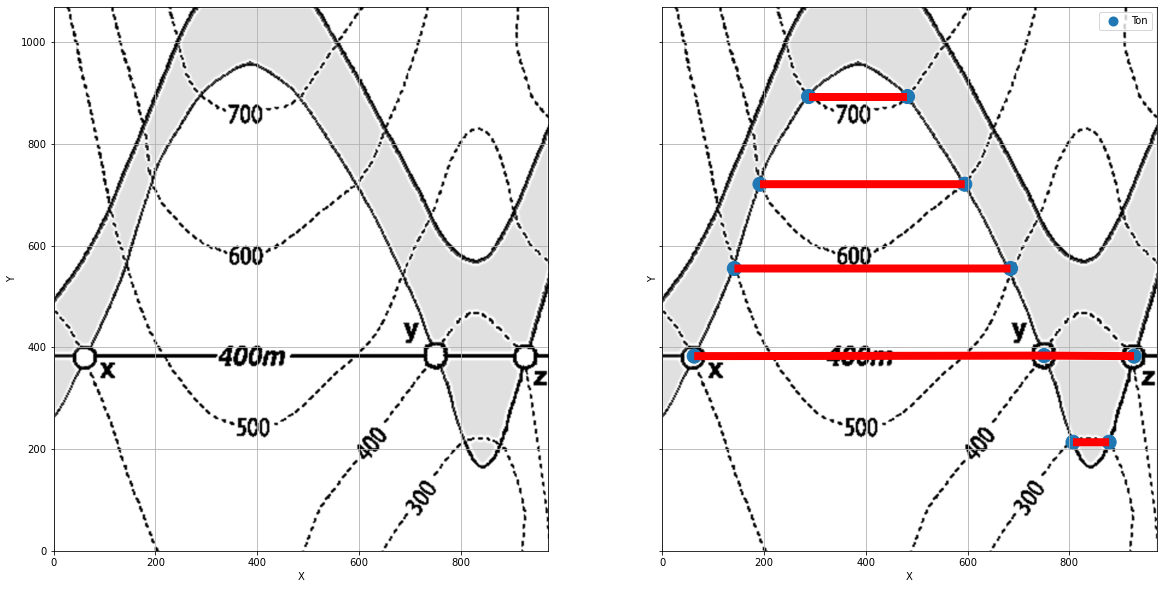

In [8]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, s = 200)
linestring_gdf.plot(ax=ax2, linewidth=8, color='red')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Calculate Orientations

Orientations are calculated for one formation with eigenvector analysis. The orientations are then returned for the midpoint of each strike line and the DataFrame can directly be used for `GemPy`. Examples with multiple formations follow.

In [9]:
orientations = gg.utils.calculate_orientations(gdf)
orientations

X           Y      Z        dip     azimuth  polarity formation
0  580.192686  383.163488  400.0  30.501488  179.976929         1       Ton
1  413.001776  555.154260  500.0  30.167326  179.982934         1       Ton
2  393.221715  720.945639  600.0  31.097049  180.000516         1       Ton
3  384.724148  893.302149  700.0  30.122015  180.000857         1       Ton

## Plot Orientations

(0.0, 972.0)

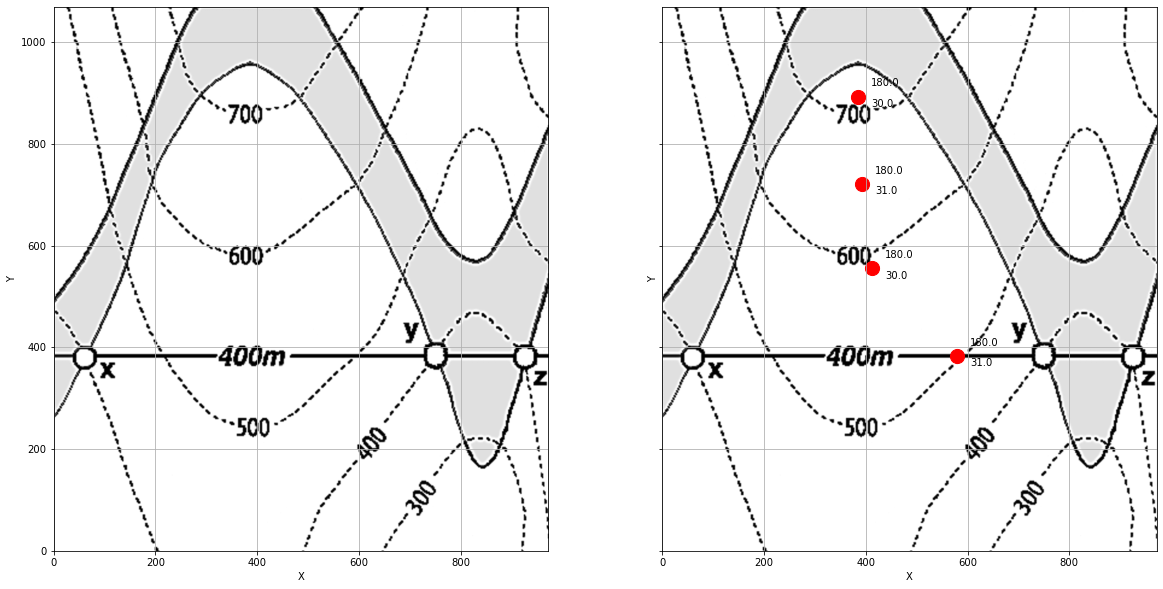

In [10]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(20, 10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
# Plotting the interfaces on the geological map
ax2.scatter(orientations['X'], orientations['Y'], s=200, color='red')
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]+20,
          s=round(orientations['azimuth'][i])) for i in range(len(orientations))]
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]-20,
          s=round(orientations['dip'][i])) for i in range(len(orientations))]

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Example 2 - Extract Orientations from a NW-SE striking fold

The second example shows a NW-SE strinking anticline. 

<img src='../../gemgis/data/examples/example2/task2.png' width="300">

## Load Data

In [11]:
geological_map = rasterio.open('../../gemgis/data/examples/example2/task2.tif')
gdf = gpd.read_file('../../gemgis/data/examples/example2/lines_strike.shp')

## Inspect Data

In [12]:
gdf.head()

id    Z formation                                   geometry
0   1  100    Layer1   LINESTRING (2.577 102.527, 78.137 1.951)
1   2  150    Layer1  LINESTRING (3.720 276.250, 208.683 2.713)
2   3  200    Layer1  LINESTRING (1.942 442.607, 335.546 1.697)
3   4  250    Layer1  LINESTRING (1.307 583.693, 438.662 6.395)
4   5  300    Layer1  LINESTRING (1.815 721.604, 544.572 2.967)

## Set Extent

In [13]:
extent = gg.utils.set_extent(0,865,0,866)
extent

[0, 865, 0, 866]

## Plot Data

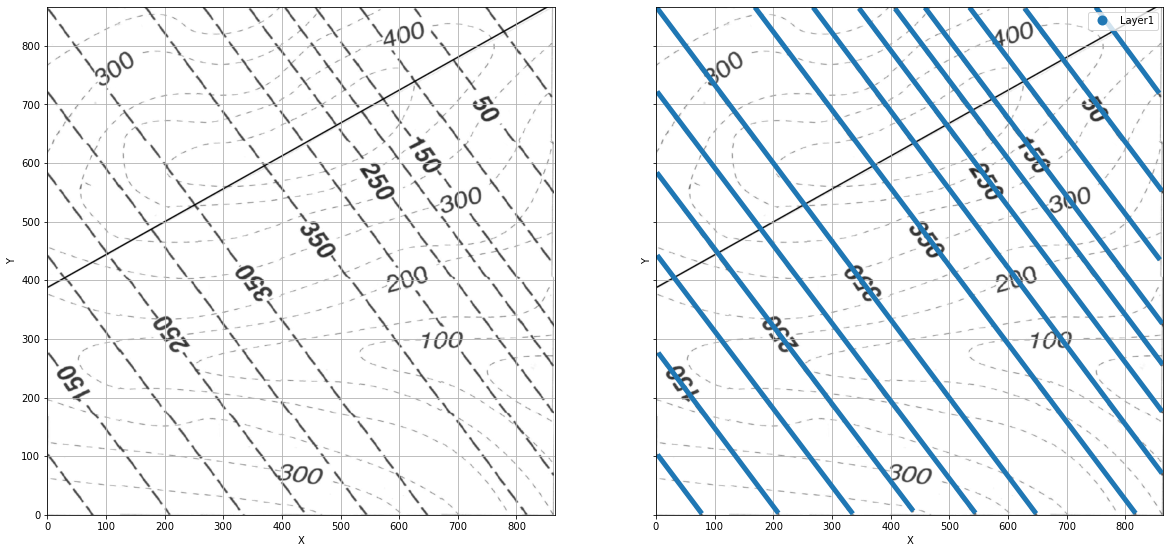

In [14]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(20,10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin = 'lower', cmap ='gray')
# Plotting the interfaces on the geological map
gdf.plot(ax=ax2, column = 'formation', legend = True, linewidth = 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2],extent[3])
ax1.set_xlim(extent[0],extent[1]);

## Calculate Orientations

Orientations are calculated for one formation with eigenvector analysis. The orientations are then returned for the midpoint of each strike line and the DataFrame can directly be used for `GemPy`. Examples with multiple formations follow.

In [38]:
orientations = calculate_orientations(gdf)
orientations

X           Y      Z        dip     azimuth  polarity formation
0   106.201410  139.481049  150.0  25.460798  233.147077         1    Layer1
1   168.744098  222.151687  200.0  26.627645  232.961921         1    Layer1
2   219.984654  295.044078  250.0  30.508464  232.865763         1    Layer1
3   273.193560  362.285403  300.0  31.065011  232.904430         1    Layer1
4   324.783340  433.336435  350.0  30.774233  233.059777         1    Layer1
5   493.108887  433.971387  350.0   0.000000    0.000000         1    Layer1
6   565.302831  468.068263  300.0  32.587961   53.108498         1    Layer1
7   604.542811  520.007266  250.0  38.631888   53.130774         1    Layer1
8   635.782407  559.755207  200.0  45.663765   53.067311         1    Layer1
9   660.953469  595.555986  150.0  50.218861   53.074811         1    Layer1
10  696.899927  650.044432  100.0  39.116555   53.040008         1    Layer1
11  745.853662  707.762975   50.0  34.105446   52.994837         1    Layer1
12  804.022335  792.183197    0.0  27.224555   53.147713         1    Layer1

## Plot Orientations

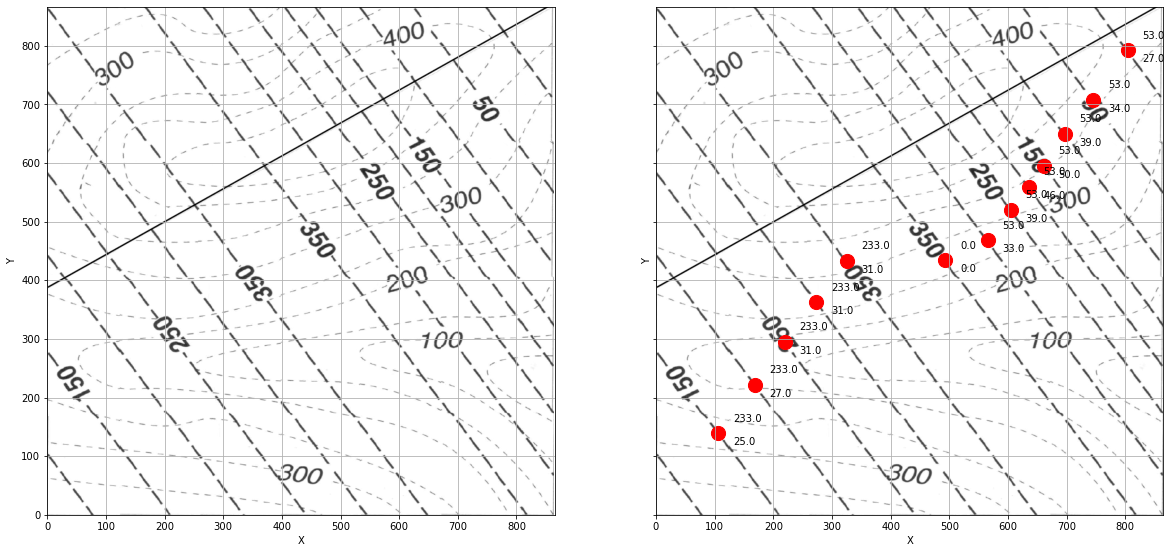

In [40]:
# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(
    ncols=2, sharex=True, sharey=True, figsize=(20, 10))
# Plotting the geological map
ax1.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1])

# Plotting the geological map
ax2.imshow(np.flipud(geological_map.read(1)), origin='lower', cmap='gray')
# Plotting the interfaces on the geological map
ax2.scatter(orientations['X'], orientations['Y'], s=200, color='red')
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]+20,
          s=round(orientations['azimuth'][i])) for i in range(len(orientations))]
[ax2.text(orientations['X'][i]+25, orientations['Y'][i]-20,
          s=round(orientations['dip'][i])) for i in range(len(orientations))]

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.grid()
ax1.set_ylim(extent[2], extent[3])
ax1.set_xlim(extent[0], extent[1]);